In [1]:
import math
import h5py
import numpy as np
import netCDF4 as nc
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib.pyplot as plt
import time
import pandas as pd
import datetime
import random
import copy

import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import from_numpy
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn
import torch.optim as optim


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from functools import partial

2.2.1+cu121


In [2]:
class Net(nn.Module):
    def __init__(self, p):
        super(Net, self).__init__()
        self.p = p
        self.conv1 = nn.Conv2d(1, 32, stride = (3,3), kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, stride = (2,2), kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size = 3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 4 * 6, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)  # 1 output value
        self.dropout = nn.Dropout(p = self.p)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 8 * 4 * 6)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Net(0.3)
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=192, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [3]:
ds3 = xr.open_dataset("real_world_sst.nc", decode_times=False)
ds3

<xarray.Dataset> Size: 32MB
Dimensions:  (time: 72, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 576B 0 365 730 1096 1461 ... 24837 25202 25567 25933
Data variables:
    SST      (time, lat, lon) float64 32MB ...

In [4]:
PRECT_real = pd.read_csv('real_world_prect.csv')
PRECT_real = PRECT_real.set_index(['year', 'region'])
PRECT_real.drop(columns=['Unnamed: 0'], inplace=True)
PRECT_real.head()

,,PRECT
year,region,
1950,North,-1.252478
1951,North,6.405958
1952,North,0.244133
1953,North,-1.394033
1954,North,-9.740346


In [5]:
PRECT_real.iloc[:72]

,,PRECT
year,region,
1950,North,-1.252478
1951,North,6.405958
1952,North,0.244133
1953,North,-1.394033
1954,North,-9.740346
...,...,...
2017,North,-2.956598
2018,North,8.708916
2019,North,-7.257689


In [6]:
y= PRECT_real.to_numpy()
y.shape

(216, 1)

In [7]:
y = y[:72]
y.shape

(72, 1)

In [8]:
X = ds3['SST'].to_numpy()

In [9]:
X = X[:72, :, :]
X.shape

(72, 192, 288)

In [10]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [11]:
BATCH_SIZE = 32
X_train = X[:40,:,:]
X_test = X[:, :, :]
y_train = y[:40,:]
y_test = y[:, :]

X_train = from_numpy(X_train).float()
y_train = from_numpy(y_train).float()

X_test = from_numpy(X_test).float()
y_test = from_numpy(y_test).float()

X_train = X_train.view(-1, 192, 288)
y_train = y_train.view(-1, 1)

X_test = X_test.view(-1, 192, 288)
y_test = y_test.view(-1, 1)

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False)
dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
X_test.shape

torch.Size([72, 192, 288])

In [13]:
train_losses = []
valid_losses = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    epoch_loss = 0  # Initialize epoch loss
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X = X.unsqueeze(1)
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        pred = model(X)

        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

        if batch % 36 == 0:
            loss, current = loss.item(), batch * BATCH_SIZE + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    epoch_avg_loss = epoch_loss / num_batches
    train_losses.append(epoch_avg_loss)


def test_valid_loop(dataloader, model, loss_fn, valid = True):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            # Prepare Data
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            X = X.unsqueeze(1)
            # make predictions and calculate loss and accuracy
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    
    # Print either Validation or Test error
    if valid:
      print(f"Validation Loss: {test_loss:>8f} \n")
      valid_losses.append(test_loss)
    else:
      print(f"Test Loss: {test_loss:>8f} \n")

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
tuned_p = 0
tuned_lr = 0.0001

model = Net(tuned_p)
model.to(device)

# Freeze all layers except the final FC layer
for param in model.parameters():
    param.requires_grad = False

# Set requires_grad=True for parameters in the final FC layer
for param in model.fc3.parameters():
    param.requires_grad = True

#ADD PATH FOR BEST MODEL WEIGHTS
model.load_state_dict(torch.load('North_Final_Weights_Sim.pth', map_location=device))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=tuned_lr)
epochs = 15

best_loss = np.inf
# patience = 30
# no_improvement_counter = 0

train_losses = []
valid_losses = []

for t in range(epochs):
    
    # if no_improvement_counter >= patience:
    #    break

    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader_train, model, loss_fn, optimizer)
    #test_valid_loop(dataloader_valid, model, loss_fn)

    # if valid_losses[t] < best_loss:
    #    best_loss = valid_losses[t]
    #    no_improvement_counter = 0
    #    best_model_weights = copy.deepcopy(model.state_dict())
    # else:
    #    no_improvement_counter += 1
    
print("Done!")

Epoch 1
-------------------------------
loss: 47.648949  [   32/   40]
Epoch 2
-------------------------------
loss: 47.646439  [   32/   40]
Epoch 3
-------------------------------
loss: 47.644058  [   32/   40]
Epoch 4
-------------------------------
loss: 47.641685  [   32/   40]
Epoch 5
-------------------------------
loss: 47.639313  [   32/   40]
Epoch 6
-------------------------------
loss: 47.636940  [   32/   40]
Epoch 7
-------------------------------
loss: 47.634579  [   32/   40]
Epoch 8
-------------------------------
loss: 47.632217  [   32/   40]
Epoch 9
-------------------------------
loss: 47.629860  [   32/   40]
Epoch 10
-------------------------------
loss: 47.627502  [   32/   40]
Epoch 11
-------------------------------
loss: 47.625153  [   32/   40]
Epoch 12
-------------------------------
loss: 47.622803  [   32/   40]
Epoch 13
-------------------------------
loss: 47.620453  [   32/   40]
Epoch 14
-------------------------------
loss: 47.618114  [   32/   40]
E

In [16]:
def r_squared(actual, predicted):
    # Calculate mean of actual values
    mean_actual = np.mean(actual)
    
    # Calculate sum of squared differences between actual and predicted values
    ss_residual = np.sum((actual - predicted) ** 2)
    
    # Calculate sum of squared differences between actual and mean values
    ss_total = np.sum((actual - mean_actual) ** 2)
    
    # Calculate R-squared
    r2 = 1 - (ss_residual / ss_total)
    
    return r2


actual_values = np.array(y_test.squeeze(1))

# # Instantiate model
#model_best_weights = Net(tuned_p)
#model_best_weights.to(device)

# # Load the best model weights
#model_best_weights.load_state_dict(best_model_weights)

#model_best_weights.load_state_dict(torch.load('12kparams_model_weights_r2_1434.pth', map_location=device))

X_test.to(device)
# Set the model to evaluation mode
#model_best_weights.eval()
model.eval()
#predicted_values = model_best_weights(X_test.unsqueeze(1).to(device)).squeeze(1).detach().cpu().numpy()
predicted_values = model(X_test.unsqueeze(1).to(device)).squeeze(1).detach().cpu().numpy()

r_squared_value = r_squared(actual_values, predicted_values)
print("R-squared:", r_squared_value)

R-squared: 0.01752525568008423


In [17]:
torch.save(model.state_dict(),'North_Final_Weights_Real_World.pth')

In [18]:
pred_dict = dict()
pred_dict2 = dict()

for i in range(72):
    pred_dict[i] = actual_values[i]
    pred_dict2[i] = predicted_values[i]

actual_df = pd.DataFrame(list(pred_dict.items()), columns=['Year', 'Actual PRECT'])
pred_df = pd.DataFrame(list(pred_dict2.items()), columns=['Year', 'Predicted PRECT'])

# Merge the DataFrames on 'Epoch' column
actual_pred_df = pd.merge(actual_df, pred_df, on='Year')

In [19]:
actual_pred_df['Year'] = actual_pred_df['Year'] + 1950
actual_pred_df

,Year,Actual PRECT,Predicted PRECT
0,1950,-1.252478,-2.064919
1,1951,6.405958,-1.047483
2,1952,0.244133,-1.928136
3,1953,-1.394033,-0.770463
4,1954,-9.740346,-1.490150
...,...,...,...
67,2017,-2.956598,-2.015161
68,2018,8.708916,-2.130970
69,2019,-7.257689,-1.721207
70,2020,-6.163958,0.917347


In [20]:
actual_pred_df.to_csv("north_real_preds.csv")

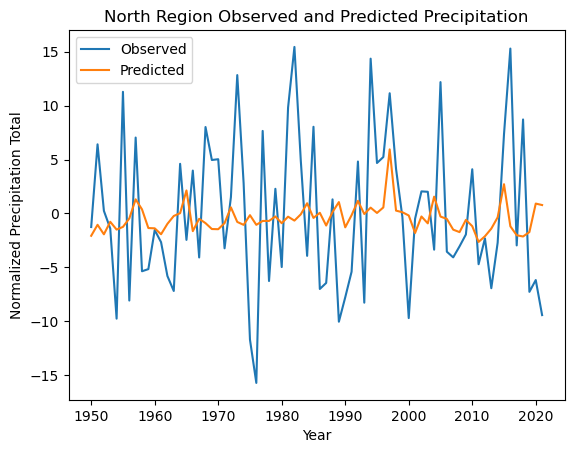

In [21]:
plt.plot(actual_pred_df['Year'], actual_pred_df['Actual PRECT'], label='Observed')
plt.plot(actual_pred_df['Year'], actual_pred_df['Predicted PRECT'], label='Predicted')
plt.xlabel('Year')
plt.ylabel('Normalized Precipitation Total')
plt.title('North Region Observed and Predicted Precipitation')
plt.legend()
plt.show()

In [22]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from PIL import Image
from cartopy.util import add_cyclic_point
import cartopy
import cartopy.crs as ccrs
from captum.attr import Saliency
from captum.attr import visualization as viz
from PIL import Image
import cartopy.io.shapereader as shpreader
from captum.attr import GuidedGradCam

/home/vkr7yx/.local/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


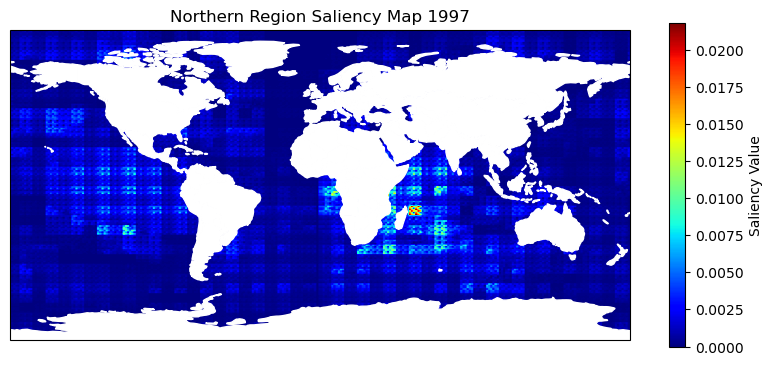

In [23]:
longitude = ds3['lon'].values
latitude = ds3['lat'].values

# Generate a sample input tensor
input_data = X_test[47].unsqueeze(0)

# Create a Saliency object for your model
saliency = Saliency(model)

# Compute the saliency map
saliency_map = saliency.attribute(input_data.to(device))

# Convert saliency map to NumPy array
saliency_map_np = saliency_map.cpu().detach().numpy()

saliency_map_np = np.flipud(saliency_map_np.squeeze())

# Resize the saliency map to match latitude and longitude dimensions
saliency_map_resized = np.array(Image.fromarray(saliency_map_np).resize((len(longitude), len(latitude))))

# Add cyclic point to the data
saliency_map_cyclic, longitude_cyclic = add_cyclic_point(saliency_map_resized, coord=longitude)

# Plot the saliency map
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Overlay the saliency map
img = ax.imshow(saliency_map_cyclic, origin='upper', extent=[longitude_cyclic.min(), longitude_cyclic.max(), latitude.min(), latitude.max()], transform=ccrs.PlateCarree(), cmap='jet')

# Add country outlines and fill them in white
shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

for country in countries:
    ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='white', edgecolor='white')

cbar = plt.colorbar(img, ax=ax, orientation='vertical', shrink=0.7)
cbar.set_label('Saliency Value')

plt.title('Northern Region Saliency Map 1997')
plt.show()